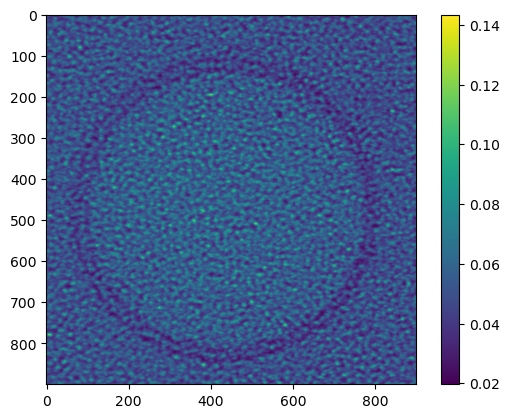

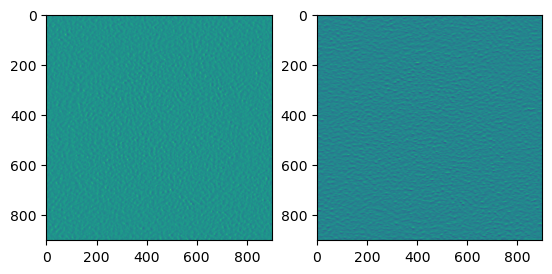

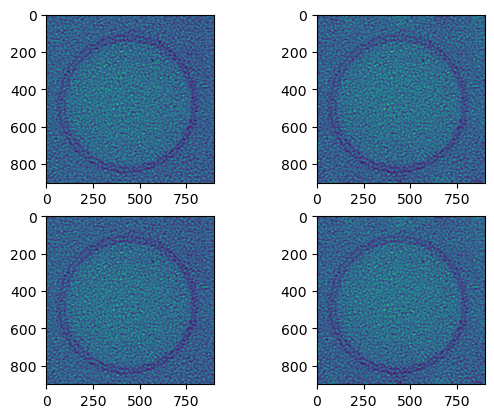

In [2]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

from mbipy.numpy.normal_integration import kottler, frankot_chellappa

with h5py.File("mbipy/data/BeLens.h5", "r") as f:
    image = f["50"]["sample"][0]
    image = image.astype(np.float64) / np.iinfo(image.dtype).max


plt.figure()
plt.imshow(image)
plt.colorbar()

gy, gx = np.gradient(image)

fig, axs = plt.subplots(1, 2)
axs[0].imshow(gx)
axs[1].imshow(gy)

result_kottler = kottler(gx=gx, gy=gy)
result_kottler_nopad = kottler(gx=gx, gy=gy, pad=False)

result_frankot = frankot_chellappa(gx=gx, gy=gy)
result_frankot_nopad = frankot_chellappa(gx=gx, gy=gy, pad=False)

fig, axs = plt.subplots(2, 2)
axs[0, 0].imshow(result_kottler)
axs[0, 1].imshow(result_kottler_nopad)
axs[1, 0].imshow(result_frankot)
axs[1, 1].imshow(result_frankot_nopad)

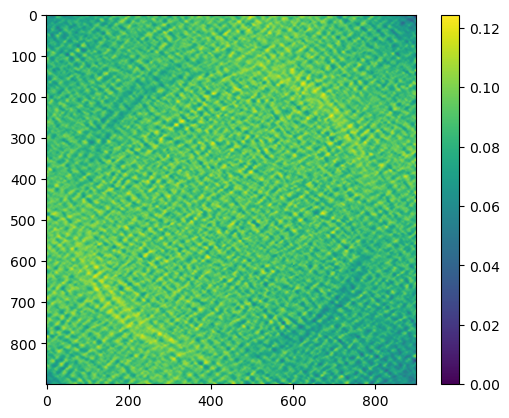

In [17]:
import numpy as np
from scipy import fft

def DCT_Poisson(p, q):
    # Divergence of (p, q) using central differences
    px = 0.5 * (np.roll(p, -1, axis=0) - np.roll(p, 1, axis=0))
    qy = 0.5 * (np.roll(q, -1, axis=1) - np.roll(q, 1, axis=1))

    # Div(p, q)
    f = px + qy

    # Right-hand side of the boundary condition
    b = np.zeros_like(p)
    b[0, 1:-1] = -p[0, 1:-1]
    b[-1, 1:-1] = p[-1, 1:-1]
    b[1:-1, 0] = -q[1:-1, 0]
    b[1:-1, -1] = q[1:-1, -1]
    b[0, 0] = (1 / np.sqrt(2)) * (-p[0, 0] - q[0, 0])
    b[0, -1] = (1 / np.sqrt(2)) * (-p[0, -1] + q[0, -1])
    b[-1, -1] = (1 / np.sqrt(2)) * (p[-1, -1] + q[-1, -1])
    b[-1, 0] = (1 / np.sqrt(2)) * (p[-1, 0] - q[-1, 0])

    # Modification near the boundaries to enforce the non-homogeneous Neumann BC
    f[0, 1:-1] -= b[0, 1:-1]
    f[-1, 1:-1] -= b[-1, 1:-1]
    f[1:-1, 0] -= b[1:-1, 0]
    f[1:-1, -1] -= b[1:-1, -1]

    # Modification near the corners
    f[0, -1] -= np.sqrt(2) * b[0, -1]
    f[-1, -1] -= np.sqrt(2) * b[-1, -1]
    f[-1, 0] -= np.sqrt(2) * b[-1, 0]
    f[0, 0] -= np.sqrt(2) * b[0, 0]

    # Cosine transform of f
    fcos = fft.dctn(f, axes=(-2, -1))

    # Cosine transform of z
    x, y = np.meshgrid(np.arange(p.shape[1]), np.arange(p.shape[0]))
    denom = 4 * ((np.sin(0.5 * np.pi * x / p.shape[1]))**2 + (np.sin(0.5 * np.pi * y / p.shape[0]))**2)
    z_bar_bar = -fcos / np.maximum(np.finfo(float).eps, denom)

    # Inverse cosine transform
    z = fft.idctn(z_bar_bar, axes=(-2, -1))
    z = z - np.min(z)  # Z known up to a positive constant, so offset it to get from 0 to max

    return z

plt.imshow(DCT_Poisson(gx, gy))
plt.colorbar()